# APRIL: Finding the Achilles' Heel on Privacy for Vision Transformers

This notebook shows an example for a **single image gradient inversion** as described in "APRIL: Finding the Achilles' Heel on Privacy for Vision Transformers
". The setting is a modified (VGG-style) ViT and the federated learning algorithm is **fedSGD**.

Paper URL: https://arxiv.org/abs/2112.14087

This is the analytic attack portion of APRIL. They also propose a variation that can be used as regularization for an optimization-based attack (but is not included in this framework so far).

#### Abstract
Federated learning frameworks typically require collaborators to share their local gradient updates of a common model instead of sharing training data to preserve privacy. However, prior works on Gradient Leakage Attacks showed that private training data can be revealed from gradients. So far almost all relevant works base their attacks on fully-connected or convolutional neural networks. Given the recent overwhelmingly rising trend of adapting Transformers to solve multifarious vision tasks, it is highly valuable to investigate the privacy risk of vision transformers. In this paper, we analyse the gradient leakage risk of self-attention based mechanism in both theoretical and practical manners. Particularly, we propose APRIL - Attention PRIvacy Leakage, which poses a strong threat to self-attention inspired models such as ViT. Showing how vision Transformers are at the risk of privacy leakage via gradients, we urge the significance of designing privacy-safer Transformer models and defending schemes.

### Environment:
* This notebook additionally requires the `timm` package to be installed.

### Startup

In [1]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will load the full configuration object. This includes the configuration for the use case and threat model as `cfg.case` and the hyperparameters and implementation of the attack as `cfg.attack`. All parameters can be modified below, or overriden with `overrides=` as if they were cmd-line arguments.

In [2]:
cfg = breaching.get_config(overrides=["attack=april_analytic", "case.model=vit_small_april"])
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type honest_but_curious.


{'device': device(type='cuda'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations for the attack, or the case:

In [3]:
cfg.case.data.partition="unique-class"
cfg.case.user.user_idx = 24

cfg.case.user.num_data_points = 1 # The attack is designed for only one data point
cfg.case.server.pretrained = True
cfg.case.user.provide_labels = False

### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Downloading: "https://storage.googleapis.com/vit_models/augreg/S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz" to /home/jonas/.cache/torch/hub/checkpoints/S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz

Model architecture vit_small_april loaded with 22,049,896 parameters and 0 buffers.
Overall this is a data ratio of     146:1 for target shape [1, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 1

    Threat model:
    User provides labels: False
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 24
    
        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: vit_small_april
        model state: d

### Simulate an attacked FL protocol

This exchange is a simulation of a single query in a federated learning protocol. The server sends out a `server_payload` and the user computes an update based on their private local data. This user update is `shared_data` and contains, for example, the parameter gradient of the model in the simplest case. `true_user_data` is also returned by `.compute_local_updates`, but of course not forwarded to the server or attacker and only used for (our) analysis.

In [5]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

Computing user update in model mode: eval.


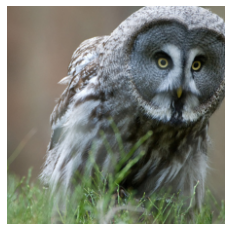

In [6]:
user.plot(true_user_data)

### Reconstruct user data:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

In [7]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)

Attention Inversion:  ||A||=4.718133380638774, ||b||=114.9629803817029
Embedding Inversion:  ||A||=26.286054163313633, ||b||=293.1851144736545


Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

In [8]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

METRICS: | MSE: 0.0041 | PSNR: 23.90 | FMSE: 3.9288e-03 | LPIPS: 0.12|
 R-PSNR: 26.32 | IIP-pixel: 100.00% | SSIM: 0.8111 | max R-PSNR: 26.32 | max SSIM: 0.8111 | Label Acc: 0.00%


And finally, we also plot the reconstructed data:

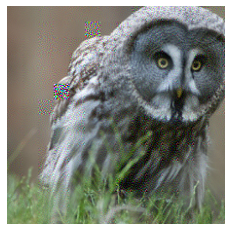

In [9]:
user.plot(reconstructed_user_data)

### Notes:
* The recovery algorithm used here is "only" a linear least squares solver. Using an actual nonlinear solver, as used for reconstruction from linear measurements in inverse problems via total variation regularization (for example with an implementation as described in https://link.springer.com/article/10.1007/s10851-010-0251-1) could further boost performance and remove some of the noisy patches that arise.
* The boost in performance in R-PSNR vs PSNR is entirely an artefact of the (inevitable) smoothing of the image during the image registration for the registered PSNR.
* Labels can be reconstructed using any one of the label recovery algorithms but are not necessary for the attack.